✅ Data loaded successfully!
Train shape: (421570, 5)
Test shape: (115064, 4)
Stores shape: (45, 3)
✅ Validation RMSE: 3708.4887048413516
 Submission file saved as submission.csv


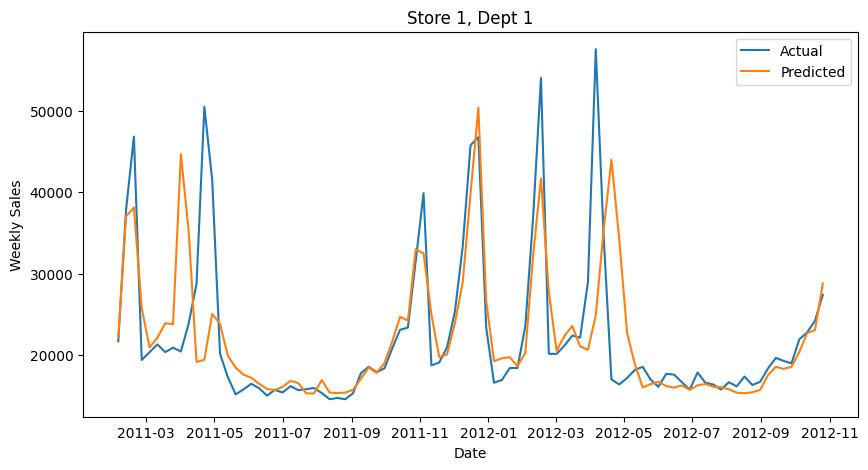

In [32]:
# =====================================
# Walmart Sales Prediction with Preprocessing
# =====================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# -----------------------------------
# Load the Data
# -----------------------------------
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")

print("✅ Data loaded successfully!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Stores shape:", stores.shape)

# -----------------------------------
# Merge Store Info
# -----------------------------------
train = train.merge(stores, on="Store", how="left")
test = test.merge(stores, on="Store", how="left")

# -----------------------------------
# Encode 'Type' (for categorical feature)
# -----------------------------------
le = LabelEncoder()
train['Type'] = le.fit_transform(train['Type'])
test['Type'] = le.transform(test['Type'])

# -----------------------------------
# Convert Date + Create Time Features
# -----------------------------------
for df in [train, test]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['dayofweek'] = df['Date'].dt.dayofweek

# -----------------------------------
# Create Lag Features
# -----------------------------------
def create_lag_features(df):
    df = df.sort_values(['Store', 'Dept', 'Date'])
    df['lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
    df['lag_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)
    df['lag_52'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)
    return df

train = create_lag_features(train)

# Drop rows with missing lag values
train = train.dropna(subset=['lag_1', 'lag_4', 'lag_52'])

# -----------------------------------
#  Define Features & Target
# -----------------------------------
FEATURES = ['Store', 'Dept', 'Type', 'Size', 'year', 'month', 'week', 'dayofweek',
            'lag_1', 'lag_4', 'lag_52']
TARGET = 'Weekly_Sales'

X = train[FEATURES]
y = train[TARGET]

# -----------------------------------
#  Train/Test Split
# -----------------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------
#  Train Linear Regression
# -----------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# -----------------------------------
# Validation Performance (RMSE)
# -----------------------------------
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred) ** 0.5
print("✅ Validation RMSE:", rmse)

# -----------------------------------
# Predict on Test Set
# -----------------------------------
test['lag_1'] = 0
test['lag_4'] = 0
test['lag_52'] = 0

test_X = test[FEATURES]
test['Weekly_Sales'] = model.predict(test_X)

# -----------------------------------
#  Save Predictions
# -----------------------------------
test[['Store', 'Dept', 'Date', 'Weekly_Sales']].to_csv("submission.csv", index=False)
print(" Submission file saved as submission.csv")

# -----------------------------------
# Plot Actual vs Predicted for a Sample
# -----------------------------------
sample_store = 1
sample_dept = 1

sample = train[(train['Store'] == sample_store) & (train['Dept'] == sample_dept)].copy()

if not sample.empty:
    sample = sample.sort_values("Date")
    sample_X = sample[FEATURES]
    sample['Predicted'] = model.predict(sample_X)

    plt.figure(figsize=(10, 5))
    plt.plot(sample['Date'], sample['Weekly_Sales'], label='Actual')
    plt.plot(sample['Date'], sample['Predicted'], label='Predicted')
    plt.title(f"Store {sample_store}, Dept {sample_dept}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.show()
else:
    print(f" No data found for Store {sample_store}, Dept {sample_dept} to plot.")


In [33]:
# ===== BONUS SECTION START =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

# --- Try Seasonal Decomposition ---
store_id, dept_id = 1, 1
sample = df[(df["Store"] == store_id) & (df["Dept"] == dept_id)].copy()
sample = sample.sort_values("Date")

if len(sample) >= 104:
    sample_series = sample.set_index("Date")["Weekly_Sales"]
    decomposition = seasonal_decompose(sample_series, model="additive", period=52)
    decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition - Store {store_id} Dept {dept_id}")
    plt.show()
else:
    print(f"Not enough data for full seasonal decomposition (need ≥104, have {len(sample)}).")

# --- Add Rolling Average Feature ---
df = df.sort_values(["Store", "Dept", "Date"])
df["Rolling_Mean_4"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# --- Prepare Data for XGBoost ---
features = ["Store", "Dept", "IsHoliday", "Rolling_Mean_4"]
X = df[features]
y = df["Weekly_Sales"]

# Ensure numeric dtypes only
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = pd.to_numeric(y, errors='coerce').fillna(0)

# --- Time-Aware Validation (TimeSeriesSplit) ---
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    xgb_model.fit(X_train.values, y_train.values)  # ✅ Ensure numeric array
    y_pred_xgb = xgb_model.predict(X_val.values)

    rmse = np.sqrt(mean_squared_error(y_val.values, y_pred_xgb))
    rmse_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.2f}")

print(f"\nAverage XGBoost RMSE: {np.mean(rmse_scores):.2f}")

# ===== BONUS SECTION END =====


Not enough data for full seasonal decomposition (need ≥104, have 39).
Fold 1 RMSE: 59.46
Fold 2 RMSE: 58.31
Fold 3 RMSE: 58.47
Fold 4 RMSE: 61.21
Fold 5 RMSE: 58.78

Average XGBoost RMSE: 59.25
